In [1]:
import pandas as pd
import numpy as np
import re
import os
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.discrete.discrete_model import NegativeBinomial
from patsy.contrasts import Treatment
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pickle import dump

In [2]:
"""
Define I/O info
"""
# path to input directory
inDIR = '/mnt/c/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/data/'
# file name of gridded path intensity data (output from gps_to_gridded_path_intensity.ipynb)
griddata_f = '2017_grazing_time_gridded_all_extracted.csv'

# path to output directory
outDIR = '/mnt/c/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/models/'

if not os.path.exists(outDIR):
    os.mkdir(outDIR)

if not os.path.exists(os.path.join(outDIR, 'seas/')):
    os.mkdir(os.path.join(outDIR, 'seas/'))
    
if not os.path.exists(os.path.join(outDIR, 'results_tables/')):
    os.mkdir(os.path.join(outDIR, 'results_tables/'))

In [3]:
"""
Load data and check data types
"""
df_wkly_grid_full = pd.read_csv(os.path.join(inDIR, griddata_f))
display(df_wkly_grid_full.dtypes)

index_id          int64
mod_data         object
week              int64
Pasture          object
Steer_ID         object
UTM_X           float64
UTM_Y           float64
grazing_secs    float64
TPC             float64
dFence          float64
dTank           float64
PC_dmt           object
PC_pct          float64
PC_div          float64
Biomass         float64
CP              float64
DOM             float64
dCorner         float64
TPC_c            object
dtype: object

In [4]:
"""
Add season to dataset based on week
"""

def season_func(wk):
    if wk <= 26:
        return 'early'
    elif wk <= 32:
        return 'mid'
    elif wk >= 33:
        return 'late'

df_wkly_grid_full['season'] = df_wkly_grid_full['week'].apply(lambda x: season_func(x))
df_wkly_grid_full['season'] = pd.Categorical(df_wkly_grid_full['season'], ['early', 'mid', 'late'])

'Number of grazing values > 10,000 = 2'

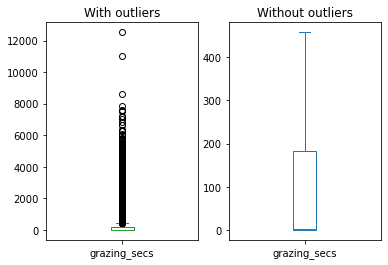

In [5]:
"""
Check grazing intensity values for further cleaning
"""
max_graze_secs = 10000
fig, axs = plt.subplots(nrows=1, ncols=2)
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=True, ax=axs[0], title='With outliers')
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=False, ax=axs[1], title='Without outliers')
display('Number of grazing values > ' + "{:,}".format(max_graze_secs) + ' = ' + "{:,}".format(
    len(df_wkly_grid_full[df_wkly_grid_full['grazing_secs'] > 10000])))

In [6]:
# mask grid cells with seemingly erroneous grazing intensity
df_wkly_grid_full.loc[df_wkly_grid_full['grazing_secs'] > max_graze_secs, 'grazing_secs'] = np.nan

In [7]:
"""
Remove data in corners and near water tanks
"""
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dTank'] > 60]
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dCorner'] > 60]

In [8]:
"""
Flag and remove any outliers beyond last 60-sec bin with only one pixel
"""

def flag_graze_outliers(x, bins=np.arange(-5, 10000, 60)):
    groups = x.groupby(pd.cut(x, bins, include_lowest=False))
    one_bins = bins[:-1][(groups.count() == 1).values] 
    gt_one_bins = bins[:-1][(groups.count() > 1).values] 
    last_one_bin = np.min([np.max(gt_one_bins) + 60, np.max([np.min(one_bins), np.max(gt_one_bins)])])
    return (x >= last_one_bin).astype('int')
    
df_wkly_grid_full['grazing_secs_outlier'] = df_wkly_grid_full.groupby(['week', 'Pasture', 'Steer_ID'])['grazing_secs'].transform(flag_graze_outliers)
print('Stats of grid cells removed across all steer-weeks:')
display(df_wkly_grid_full.groupby(['week', 'Pasture', 'Steer_ID'])['grazing_secs_outlier'].sum().describe())

Stats of grid cells removed across all steer-weeks:


count    198.000000
mean       5.782828
std        2.558614
min        2.000000
25%        4.000000
50%        5.000000
75%        7.000000
max       13.000000
Name: grazing_secs_outlier, dtype: float64

In [9]:
# remove grazing outliers
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['grazing_secs_outlier'] == 0]

In [10]:
"""
Calculate total weekly grazing seconds per steer-week to use as offset to account for missing data
"""
# get the sum total of grazing seconds for each steer-week
df_wkly_grid_full['grazing_wkly_sum'] = df_wkly_grid_full.groupby(['Pasture', 'Steer_ID', 'week'])['grazing_secs'].transform('sum')

In [11]:
"""
Calculate grazing frequency relative to expected with perfectly even grazing
"""
df_wkly_grid_full['grazing_rel_freq'] = df_wkly_grid_full['grazing_secs'] / (df_wkly_grid_full['grazing_wkly_sum'] / 
                                                                             df_wkly_grid_full.groupby(
                                                                                 ['Pasture', 'Steer_ID', 'week'])['grazing_secs'].transform('count'))
df_wkly_grid_full['grazing_rel_freq'].describe()

count    279839.000000
mean          1.000000
std           1.752067
min           0.000000
25%           0.000000
50%           0.000000
75%           1.360538
max          47.136436
Name: grazing_rel_freq, dtype: float64

In [12]:
"""
Scale variables if desired
"""
from sklearn.preprocessing import StandardScaler
scale_vars = False
scaler = StandardScaler()
if scale_vars:
    for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
        for seas in ['early', 'mid', 'late']:
            scaler.fit(df_wkly_grid_full.loc[df_wkly_grid_full['season'] == seas, c].values.reshape(-1, 1))
            with open(os.path.join(outDIR, 'scaler_' + seas + '_' + c + '.pkl'), 'wb') as f:
                dump(scaler, f)
            df_wkly_grid_full.loc[df_wkly_grid_full['season'] == seas, c] = scaler.transform(
                df_wkly_grid_full.loc[df_wkly_grid_full['season'] == seas, c].values.reshape(-1, 1)).flatten()
    #for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
    #    df_wkly_grid_full.loc[:, c] = df_wkly_grid_full.groupby(['season'])[c].transform(
    #        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
        #scaler.fit_transform(df_wkly_grid_full[c].values.reshape(-1, 1)).flatten()#.transform(
    #        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

In [13]:
"""
Organize dataset into training and testing data
"""
df_wkly_grid_test = df_wkly_grid_full[df_wkly_grid_full['mod_data'] == 'test']
df_wkly_grid = df_wkly_grid_full[df_wkly_grid_full['mod_data'] == 'train']

In [14]:
"""
Check for very rare plant community classes by pasture
"""
pc_dmt_summary = df_wkly_grid.groupby(['Steer_ID', 'Pasture', 'week'])['PC_dmt'].value_counts().groupby(
    ['Pasture', 'PC_dmt']).max().rename('value').to_frame().reset_index().pivot(index='PC_dmt', columns='Pasture')['value']
pc_dmt_summary['Total'] = pc_dmt_summary.sum(axis=1)
display(pc_dmt_summary)

Pasture,15E,17N,20SE,26E,31E,7NW,Total
PC_dmt,,,,,,,
Bare_veg,4.0,1.0,27.0,4.0,20.0,3.0,59.0
C3,NaN,27.0,475.0,3.0,13.0,1.0,519.0
C3_C4_mix,371.0,535.0,339.0,92.0,733.0,944.0,3014.0
C4,1060.0,373.0,243.0,1265.0,844.0,357.0,4142.0
Saltgrass,NaN,440.0,318.0,NaN,5.0,72.0,835.0
Shrub,NaN,2.0,14.0,NaN,NaN,11.0,27.0
UNK,NaN,10.0,9.0,17.0,11.0,2.0,49.0


In [15]:
"""
Check for very rare topographic position classes by pasture
"""
tpc_dmt_summary = df_wkly_grid.groupby(['Pasture', 'week'])['TPC_c'].value_counts().groupby(
    ['Pasture', 'TPC_c']).max().rename('value').to_frame().reset_index().pivot(index='TPC_c', columns='Pasture')['value']
tpc_dmt_summary['Total'] = tpc_dmt_summary.sum(axis=1)
display(tpc_dmt_summary)

Pasture,15E,17N,20SE,26E,31E,7NW,Total
TPC_c,,,,,,,
Flat Plains,692.0,342.0,1316.0,841.0,154.0,1901.0,5246.0
Highlands,582.0,578.0,88.0,102.0,483.0,154.0,1987.0
Lowlands,691.0,1278.0,893.0,170.0,426.0,362.0,3820.0
Open Slopes,896.0,516.0,546.0,269.0,547.0,361.0,3135.0
Other,10.0,58.0,NaN,1.0,17.0,NaN,86.0


In [16]:
"""
Combine rare classes to 'Other'
"""
#df_wkly_grid[df_wkly_grid['PC_dmt'].isin(['Bare', 'Bare_veg', 'UNK', 'Shrub'])] = 'Other'
df_wkly_grid['PC_dmt'].replace({'Bare_veg': 'Other', 'Bare': 'Other', 'UNK': 'Other', 'Shrub': 'Other'}, 
                               inplace=True)
#df_wkly_grid = df_wkly_grid[~df_wkly_grid['TPC_c'].isin(['Other'])]

# print final class numbers
print(df_wkly_grid['TPC_c'].value_counts())
print('\n')
print(df_wkly_grid['PC_dmt'].value_counts())

Flat Plains    35765
Lowlands       27099
Open Slopes    22961
Highlands      14849
Other            628
Name: TPC_c, dtype: int64


C4           46359
C3_C4_mix    35665
Saltgrass    11119
C3            6684
Other         1475
Name: PC_dmt, dtype: int64


/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [18]:
min_class_n = 10
fit_method = 'newton'
max_iters = 1000
aicw_func = lambda x: np.exp(-0.5 * (x - x.min())) / np.sum(np.exp(-0.5 * (x - x.min())))
aicd_func = lambda x: x - x.min()

m0 = 'grazing_secs ~ dFence + dTank'
m1 = m0 + ' + C(TPC_c, Treatment(reference="Flat Plains"))'
m2a = m0 + ' + Biomass'
m2b = m0 + ' + Biomass + I(Biomass**2)'
m2c = m0 + ' + CP'
m2d = m2a + ' + CP' 
m2e = m2a + ' + CP + Biomass:CP'
m2f = m2b + ' + CP'
m2g = m2b + ' + CP + Biomass:CP'
m3a = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix"))'
m3b = m0 + ' + PC_div'
m3c = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) + PC_div'
m3d = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) * PC_div'

model_dict = {
    'M0': m0,
    'M1': m1,
    'M2a': m2a,
    'M2b': m2b,
    'M2c': m2c,
    'M2d': m2d,
    'M2e': m2e,
    'M2f': m2f,
    'M2g': m2g,
    'M3a': m3a,
    'M3b': m3b,
    'M3c': m3c,
    'M3d': m3d
}

In [19]:
"""
Run the initial candidate models
"""
df_results = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC'])
idx = 0
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture', 'Steer_ID'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC'])
    
    # run initial models for negative binomial
    for i in model_dict:
        form = model_dict[i]
        #print('NB: ' + form)
        try:
            md_tmp3 = NegativeBinomial.from_formula(form, data, 
                                                    offset=np.log(data['grazing_wkly_sum']), missing='drop')
            mdf_tmp3 = md_tmp3.fit(maxiter=max_iters, method=fit_method, disp=False)
            if mdf_tmp3.mle_retvals['converged']:
                aic_tmp = round(mdf_tmp3.aic, 2)
            else:
                aic_tmp = np.nan
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'Steer_ID': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/71 [00:00<?, ?it/s]

/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1333: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + exposure + offset)
/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1334: RuntimeWarning: overflow encountered in multiply
  return -np.dot(L*X.T, X)
/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1334: RuntimeWarning: invalid value encountered in multiply
  return -np.dot(L*X.T, X)
/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1243: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)
/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1333: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params)

In [20]:
"""
Analyze the top forage condition models
"""
# calculate AIC weights for the forage condition models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICw_FC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICd_FC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_FC'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_FC'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_FC'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_FC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_FC': np.mean, 'AICw_FC': np.mean, 
          'top_model_FC': np.max, 'candidate_model_FC': np.max}).groupby(
    ['season', 'model'])[['top_model_FC', 'candidate_model_FC', 'AICw_FC', 'AICd_FC']].aggregate(
    func={'AICd_FC': [np.median, np.std], 'AICw_FC': [np.mean, np.std], 
          'top_model_FC': np.sum, 'candidate_model_FC': np.sum}, axis=1).sort_values(['season', ('AICd_FC', 'median')]))

# print the results by season and pasture
pd.set_option('display.max_rows', 150)
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_FC': np.mean, 'AICw_FC': np.mean, 
          'top_model_FC': np.max, 'candidate_model_FC': np.max}).groupby(
    ['Pasture', 'season', 'model'])[['top_model_FC', 'candidate_model_FC', 'AICw_FC', 'AICd_FC']].aggregate(
    func={'AICd_FC': [np.median, np.std], 'AICw_FC': [np.mean, np.std], 
          'top_model_FC': np.sum, 'candidate_model_FC': np.sum}, axis=1).sort_values(['Pasture', 'season', ('AICd_FC', 'median')]))

# print the overall results
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_FC': np.mean, 'AICw_FC': np.mean, 
          'top_model_FC': np.max, 'candidate_model_FC': np.max}).groupby(
    ['model'])[['top_model_FC', 'candidate_model_FC', 'AICw_FC', 'AICd_FC']].aggregate(
    func={'AICd_FC': [np.median, np.std], 'AICw_FC': [np.mean, np.std], 
          'top_model_FC': np.sum, 'candidate_model_FC': np.sum}, axis=1).sort_values(('AICd_FC', 'median')))

AICd_FC              AICw_FC           top_model_FC  \
               median        std      mean       std          sum   
season model                                                        
early  M2e     1.2750   1.357840  0.385874  0.295402          5.0   
       M2d     1.4425   5.775004  0.330210  0.216082          7.0   
       M2a     4.3475   9.241146  0.172797  0.206319          4.0   
       M2c     7.8100  18.579159  0.194631  0.246553          6.0   
       M2b        NaN        NaN       NaN       NaN          0.0   
       M2f        NaN        NaN       NaN       NaN          0.0   
       M2g        NaN        NaN       NaN       NaN          0.0   
mid    M2d     0.0475   4.120692  0.411790  0.262920          9.0   
       M2e     1.0300   0.885975  0.449579  0.274957          8.0   
       M2a    13.5650  16.233111  0.089962  0.182788          3.0   
       M2c    17.1425  14.687412  0.048669  0.092785          0.0   
       M2b        NaN        NaN       NaN       NaN          0.0   
       M2f        NaN        NaN       NaN       NaN          0.0   
       M2g        NaN        NaN       NaN       NaN          0.0   
late   M2a     0.6425   3.800737  0.308937  0.137564          7.0   
       M2d     1.6900   2.685893  0.243417  0.103385          4.0   
       M2e     2.0425   1.234999  0.295911  0.251860          4.0   
       M2c     3.1225  16.799293  0.151735  0.158916          2.0   
       M2b        NaN        NaN       NaN       NaN          0.0   
       M2f        NaN        NaN       NaN       NaN          0.0   
       M2g        NaN        NaN       NaN       NaN          0.0   

             candidate_model_FC  
                            sum  
season model                     
early  M2e                 11.0  
       M2d                 16.0  
       M2a                  6.0  
       M2c                  9.0  
       M2b                  0.0  
       M2f                  0.0  
       M2g                  0.0  
mid    M2d                 15.0  
       M2e                 17.0  
       M2a                  4.0  
       M2c                  3.0  
       M2b                  0.0  
       M2f                  0.0  
       M2g                  0.0  
late   M2a                 10.0  
       M2d                 11.0  
       M2e                  8.0  
       M2c                  7.0  
       M2b                  0.0  
       M2f                  0.0  
       M2g                  0.0

AICd_FC                  AICw_FC                \
                       median        std          mean           std   
Pasture season model                                                   
15E     early  M2c     1.8600   0.686919  2.593864e-01  1.161055e-01   
               M2d     1.8800   0.644147  2.749102e-01  1.516576e-01   
               M2e     2.9800   1.698892  2.383818e-01  1.833606e-01   
               M2a     3.3250   5.111767  2.273216e-01  2.793589e-01   
               M2b        NaN        NaN           NaN           NaN   
               M2f        NaN        NaN           NaN           NaN   
               M2g        NaN        NaN           NaN           NaN   
        mid    M2d     0.0050   2.114547  4.558141e-01  2.211978e-01   
               M2e     1.0000   0.124900  4.171399e-01  1.288446e-01   
               M2a     7.0000   3.523749  8.544542e-02  1.276152e-01   
               M2c    15.0000   6.757297  4.160055e-02  6.902815e-02   
               M2b        NaN        NaN           NaN           NaN   
               M2f        NaN        NaN           NaN           NaN   
               M2g        NaN        NaN           NaN           NaN   
        late   M2e     0.8600   0.197990  5.507485e-01  1.960124e-02   
               M2d     2.7950   0.961665  2.340997e-01  1.194076e-01   
               M2a     3.5425   1.354109  2.124632e-01  1.353479e-01   
               M2c    15.2150   4.681047  2.688605e-03  3.660941e-03   
               M2b        NaN        NaN           NaN           NaN   
               M2f        NaN        NaN           NaN           NaN   
               M2g        NaN        NaN           NaN           NaN   
17N     early  M2c     0.0000   4.514879  4.526525e-01  3.698075e-01   
               M2d     1.7600   1.035411  5.054620e-01  4.043353e-01   
               M2a    13.9800  12.927502  4.188551e-02  7.196584e-02   
               M2b        NaN        NaN           NaN           NaN   
               M2e        NaN        NaN           NaN           NaN   
               M2f        NaN        NaN           NaN           NaN   
               M2g        NaN        NaN           NaN           NaN   
        mid    M2d     0.0000   2.615397  5.305189e-01  2.801869e-01   
               M2e     1.2800   0.995188  4.694807e-01  2.801864e-01   
               M2c    29.6100   4.688905  3.488210e-07  4.034063e-07   
               M2a    36.1800   5.940110  5.691428e-08  9.060860e-08   
               M2b        NaN        NaN           NaN           NaN   
               M2f        NaN        NaN           NaN           NaN   
               M2g        NaN        NaN           NaN           NaN   
        late   M2d     0.8400   0.042426  3.287344e-01  1.135566e-02   
               M2e     2.2175   0.682358  1.990809e-01  9.824417e-02   
               M2c     3.1225   0.774282  1.437829e-01  6.961749e-02   
               M2a     3.6325   4.790648  3.284018e-01  1.792173e-01   
               M2b        NaN        NaN           NaN           NaN   
               M2f        NaN        NaN           NaN           NaN   
               M2g        NaN        NaN           NaN           NaN   
20SE    early  M2d     0.0000   1.226869  4.733078e-01  1.033035e-01   
               M2e     0.8200   0.425353  4.210816e-01  1.368126e-01   
               M2a     9.6550   2.437962  6.817340e-02  3.479829e-02   
               M2c    44.5300  28.839538  3.743712e-02  6.484295e-02   
               M2b        NaN        NaN           NaN           NaN   
               M2f        NaN        NaN           NaN           NaN   
               M2g        NaN        NaN           NaN           NaN   
        mid    M2d     0.0900   1.118079  4.041151e-01  2.615972e-01   
               M2a     0.8100   9.578147  2.572773e-01  2.828973e-01   
               M2e     1.7100   1.005037  2.821187e-01  4.503209e-02   
               M2c    14.6300   8.036237  5.648895e-02  9.7245

AICd_FC              AICw_FC           top_model_FC candidate_model_FC
       median        std      mean       std          sum                sum
model                                                                       
M2e    1.2800   1.178375  0.387366  0.276945         17.0               36.0
M2d    1.3700   4.468512  0.339104  0.220873         20.0               42.0
M2a    5.2650  13.267952  0.175898  0.197773         14.0               20.0
M2c    9.8625  16.812659  0.129171  0.187789          8.0               19.0
M2b       NaN        NaN       NaN       NaN          0.0                0.0
M2f       NaN        NaN       NaN       NaN          0.0                0.0
M2g       NaN        NaN       NaN       NaN          0.0                0.0

In [20]:
"""
Analyze the top plant community models
"""
# calculate AIC weights and delta for the plant community models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICw_PC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICd_PC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_PC'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_PC'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_PC'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_PC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_PC': np.mean, 'AICw_PC': np.mean, 
          'top_model_PC': np.max, 'candidate_model_PC': np.max}).groupby(
    ['season', 'model'])[['top_model_PC', 'candidate_model_PC', 'AICw_PC', 'AICd_PC']].aggregate(
    func={'AICd_PC': [np.median, np.std], 'AICw_PC': [np.mean, np.std],
          'top_model_PC': np.sum, 'candidate_model_PC': np.sum}, axis=1).sort_values(['season', ('AICd_PC', 'median')]))

# print the results by season and pasture
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_PC': np.mean, 'AICw_PC': np.mean, 
          'top_model_PC': np.max, 'candidate_model_PC': np.max}).groupby(
    ['Pasture', 'season', 'model'])[['top_model_PC', 'candidate_model_PC', 'AICw_PC', 'AICd_PC']].aggregate(
    func={'AICd_PC': [np.median, np.std], 'AICw_PC': [np.mean, np.std],
          'top_model_PC': np.sum, 'candidate_model_PC': np.sum}, axis=1).sort_values(['Pasture', ('AICd_PC', 'median')]))

# print the overall results
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_PC': np.mean, 'AICw_PC': np.mean, 
          'top_model_PC': np.max, 'candidate_model_PC': np.max}).groupby(
    ['model'])[['top_model_PC', 'candidate_model_PC', 'AICw_PC', 'AICd_PC']].aggregate(
    func={'AICd_PC': [np.median, np.std], 'AICw_PC': [np.mean, np.std], 
          'top_model_PC': np.sum, 'candidate_model_PC': np.sum}, axis=1).sort_values(('AICd_PC', 'median')))

AICd_PC              AICw_PC           top_model_PC  \
               median        std      mean       std          sum   
season model                                                        
early  M3d     1.1950   2.891297  0.420361  0.365227          9.0   
       M3c     1.4200   4.582817  0.272504  0.215228          7.0   
       M3b     5.8300   7.594944  0.206195  0.272184          6.0   
       M3a    10.5250  11.103934  0.100940  0.143439          2.0   
mid    M3b     0.7875  10.791515  0.286531  0.277545          9.0   
       M3c     2.0750   4.591483  0.205066  0.177306          2.0   
       M3a     3.0250   5.462952  0.249054  0.222819          5.0   
       M3d     3.4525   2.893370  0.263835  0.346444          4.0   
late   M3b     0.0000   8.881428  0.386858  0.288302          8.0   
       M3c     2.7875   2.388689  0.192124  0.113800          1.0   
       M3a     2.8375  11.365220  0.186655  0.144199          1.0   
       M3d     3.7700   2.715559  0.273041  0.325814          4.0   

             candidate_model_PC  
                            sum  
season model                     
early  M3d                 12.0  
       M3c                 10.0  
       M3b                  8.0  
       M3a                  4.0  
mid    M3b                 10.0  
       M3c                  9.0  
       M3a                  8.0  
       M3d                  7.0  
late   M3b                  8.0  
       M3c                  7.0  
       M3a                  5.0  
       M3d                  6.0

AICd_PC              AICw_PC           top_model_PC  \
                       median        std      mean       std          sum   
Pasture season model                                                        
15E     early  M3d     0.0000   1.316359  0.688488  0.450025          2.0   
        mid    M3a     0.1000   3.063251  0.286126  0.196856          2.0   
               M3b     0.4900   0.373976  0.322485  0.054940          2.0   
               M3c     1.6150   0.822076  0.240698  0.128768          1.0   
        late   M3c     1.7175   0.010607  0.229551  0.017037          0.0   
               M3d     1.7625   2.492551  0.324512  0.333376          1.0   
        mid    M3d     2.1850   1.303978  0.150692  0.066657          0.0   
        late   M3b     2.5325   3.581496  0.291767  0.325045          1.0   
               M3a     5.6200   2.906209  0.154170  0.025367          0.0   
        early  M3c     7.9900   4.421991  0.140230  0.159317          0.0   
               M3b    20.9450  13.291868  0.169840  0.290839          1.0   
               M3a    28.0150  12.933055  0.001443  0.002486          0.0   
17N     mid    M3d     0.0000   1.431829  0.612397  0.421635          2.0   
        early  M3d     0.3050   2.860508  0.543900  0.478922          2.0   
        late   M3d     2.1200   2.998133  0.563210  0.516280          2.0   
        mid    M3a     2.4100   6.597507  0.283158  0.328378          1.0   
        early  M3a     3.6000   7.912206  0.207650  0.251477          1.0   
        late   M3c     3.7500   1.124300  0.247424  0.247487          1.0   
               M3a     3.8525   1.693521  0.152303  0.055082          0.0   
        mid    M3c     4.1300   6.266742  0.120247  0.139371          0.0   
        early  M3b     4.2550   5.215375  0.115140  0.099666          1.0   
               M3c     5.1750   5.776409  0.133310  0.166964          0.0   
        late   M3b     9.5475  12.568823  0.269132  0.380489          1.0   
        mid    M3b    14.9050  18.014525  0.011114  0.017821          0.0   
20SE    early  M3d     0.4850   0.371786  0.460909  0.020332          3.0   
               M3c     0.6100   0.405925  0.479446  0.110389          3.0   
        mid    M3c     1.1700   1.506729  0.412944  0.297951          1.0   
        late   M3d     2.0075   2.839034  0.467458  0.542483          1.0   
        mid    M3d     3.3100   2.247984  0.341298  0.413261          1.0   
               M3a     3.9100   7.970360  0.062003  0.055188          0.0   
        late   M3c     5.1150   6.293250  0.258875  0.155853          0.0   
        mid    M3b    13.0600   8.069011  0.183754  0.316880          1.0   
        early  M3b    13.2500   6.925491  0.048638  0.074653          0.0   
        late   M3b    13.3325  18.855002  0.253922  0.358707          1.0   
        early  M3a    22.1350  10.939393  0.011008  0.019055          0.0   
        late   M3a    23.5725  25.954354  0.019745  0.027923          0.0   
26E     early  M3b     0.0000   2.869431  0.435229  0.390873          2.0   
        mid    M3b     0.0000   0.000000  0.468156  0.080462          3.0   
        late   M3b     0.0000   0.000000  0.456702  0.061602          2.0   
        early  M3c     0.0300   2.029442  0.397759  0.248173          1.0   
        mid    M3a     1.1400   1.618219  0.237516  0.150548          0.0   
        late   M3a     1.5200   1.074802  0.237120  0.148477          0.0   
               M3c     1.8850   1.039447  0.183729  0.068941          0.0   
        mid    M3c     2.1800   1.499200  0.208692  0.130630          0.0   
        late   M3d     3.7150   3.500179  0.122449  0.141138          0.0   
        early  M3d     3.9000   2.943626  0.129564  0.155470          0.0   
        mid    M3d     4.1000   2.762662  0.085636  0.086319          0.0   
        early  M3a    12.9300   6.406452  0.037448  0.063331          0.0   
31E     early  M3d     0.0000   5.525242  0.562921  0.506660          2.0   
        mid    M3b

AICd_PC             AICw_PC           top_model_PC candidate_model_PC
       median       std      mean       std          sum                sum
model                                                                      
M3c     2.090  4.074864  0.227120  0.180125         10.0               26.0
M3d     2.380  2.837910  0.324834  0.349443         17.0               25.0
M3b     2.970  9.100017  0.281487  0.281296         23.0               26.0
M3a     3.615  9.890286  0.177911  0.185724          8.0               17.0

In [21]:
"""
Define the top vegetation models for each season
"""
model_dict_top = {
    'early': {
        'M2_top': m2g,
        'M3_top': m3d
    },
    'mid': {
        'M2_top': m2g,
        'M3_top': m3b
    },
    'late': {
        'M2_top': m2f,
        'M3_top': m3b
    }
}

model_dict_veg = {
    'early': {},
    'mid': {},
    'late': {}
}
for seas in ['early', 'mid', 'late']:   
    m4a = model_dict_top[seas]['M2_top'] + re.sub(re.escape(m0), '', model_dict_top[seas]['M3_top'])
    model_dict_veg[seas]['M4a'] = m4a
    if 'PC_dmt' in m4a:
        if 'Biomass' in m4a:
            m4b = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):Biomass'
            model_dict_veg[seas]['M4b'] = m4b
        if 'CP' in m4a:
            m4c = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP'
            model_dict_veg[seas]['M4c'] = m4c
            if 'Biomass' in m4a:
                m4f = m4b + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP'
                model_dict_veg[seas]['M4f'] = m4f
    if 'PC_div' in m4a:
        if 'Biomass' in m4a:
            m4d = m4a + ' + PC_div:Biomass'
            model_dict_veg[seas]['M4d'] = m4d
        if 'CP' in m4a:
            m4e = m4a + ' + PC_div:CP'
            model_dict_veg[seas]['M4e'] = m4e
            if 'Biomass' in m4a:
                m4g = m4d + ' + PC_div:CP'
                model_dict_veg[seas]['M4g'] = m4g
                if 'PC_dmt' in m4a:
                    m4h = m4b + ' + PC_div:Biomass + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP + PC_div:CP'
                    model_dict_veg[seas]['M4h'] = m4h


In [22]:
"""
Run additional vegetation models
"""
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture', 'Steer_ID'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    seas = season_func(group[0][0])
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC'])
    
    # run forage condition models for negative binomial
    for i in model_dict_veg[seas]:
        form = model_dict_veg[seas][i]
        #print('NB: ' + form)
        try:
            md_tmp3 = NegativeBinomial.from_formula(form, data, 
                                                    offset=np.log(data['grazing_wkly_sum']), missing='drop')
            mdf_tmp3 = md_tmp3.fit(maxiter=max_iters, method=fit_method, disp=False)
            if mdf_tmp3.mle_retvals['converged']:
                aic_tmp = round(mdf_tmp3.aic, 2)
            else:
                aic_tmp = np.nan
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': seas,
            'Pasture': group[0][1],
            'Steer_ID': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/71 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2850: RuntimeWarning: overflow encountered in square
  const_arr = a1*mu*(a1+y)/(mu+a1)**2
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: overflow encountered in multiply
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: overflow encountered in square
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: invalid value encountered in true_divide
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2873: RuntimeWarning: overflow encountered in

In [23]:
"""
Analyze the top vegetation models
"""
# calculate AIC weights for the forage condition models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4'])), 
               'AICw_VEG'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4'])), 
               'AICd_VEG'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_VEG'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_VEG'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_VEG'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_VEG'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_VEG': np.mean, 'AICw_VEG': np.mean, 
          'top_model_VEG': np.max, 'candidate_model_VEG': np.max}).groupby(
    ['season', 'model'])[['top_model_VEG', 'candidate_model_VEG', 'AICw_VEG', 'AICd_VEG']].aggregate(
    func={'AICd_VEG': [np.median, np.std], 'AICw_VEG': [np.mean, np.std],
          'top_model_VEG': np.sum, 'candidate_model_VEG': np.sum}, axis=1).sort_values(['season', ('AICd_VEG', 'median')]))

# print the overall results
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_VEG': np.mean, 'AICw_VEG': np.mean, 
          'top_model_VEG': np.max, 'candidate_model_VEG': np.max}).groupby(
    ['model'])[['top_model_VEG', 'candidate_model_VEG', 'AICw_VEG', 'AICd_VEG']].aggregate(
    func={'AICd_VEG': [np.median, np.std], 'AICw_VEG': [np.mean, np.std], 
          'top_model_VEG': np.sum, 'candidate_model_VEG': np.sum}, axis=1).sort_values(('AICd_VEG', 'median')))

AICd_VEG            AICw_VEG           top_model_VEG  \
               median       std      mean       std           sum   
season model                                                        
early  M4a     1.4950  2.651116  0.218835  0.105916          12.0   
       M4d     2.0675  2.732203  0.173143  0.117961           3.0   
       M4e     2.4175  2.703481  0.123314  0.071264           2.0   
       M4g     2.7850  3.026384  0.110962  0.083485           2.0   
       M4c     3.1425  3.863170  0.151175  0.161885           5.0   
       M4b     3.4300  2.672466  0.140145  0.166185           3.0   
       M4f     5.4975  2.711991  0.051881  0.072291           1.0   
       M4h     6.9475  3.167404  0.040751  0.064569           1.0   
mid    M4a     0.7750  2.885152  0.285481  0.142508           8.0   
       M4e     0.8900  1.593799  0.277770  0.153275           7.0   
       M4d     1.5500  2.326025  0.217383  0.126413           3.0   
       M4g     1.8200  0.996250  0.219366  0.182503           2.0   
       M4b        NaN       NaN       NaN       NaN           0.0   
       M4c        NaN       NaN       NaN       NaN           0.0   
       M4f        NaN       NaN       NaN       NaN           0.0   
       M4h        NaN       NaN       NaN       NaN           0.0   
late   M4a     0.3425  2.041759  0.315614  0.143103           7.0   
       M4d     1.2950  1.122447  0.239911  0.110674           4.0   
       M4e     1.4475  0.888454  0.239332  0.092634           3.0   
       M4g     2.0100  1.139326  0.205143  0.133593           3.0   
       M4b        NaN       NaN       NaN       NaN           0.0   
       M4c        NaN       NaN       NaN       NaN           0.0   
       M4f        NaN       NaN       NaN       NaN           0.0   
       M4h        NaN       NaN       NaN       NaN           0.0   

             candidate_model_VEG  
                             sum  
season model                      
early  M4a                  16.0  
       M4d                  13.0  
       M4e                  15.0  
       M4g                   9.0  
       M4c                   9.0  
       M4b                   8.0  
       M4f                   1.0  
       M4h                   2.0  
mid    M4a                  15.0  
       M4e                  14.0  
       M4d                  14.0  
       M4g                  14.0  
       M4b                   0.0  
       M4c                   0.0  
       M4f                   0.0  
       M4h                   0.0  
late   M4a                  10.0  
       M4d                   9.0  
       M4e                  11.0  
       M4g                  10.0  
       M4b                   0.0  
       M4c                   0.0  
       M4f                   0.0  
       M4h                   0.0

AICd_VEG            AICw_VEG           top_model_VEG candidate_model_VEG
        median       std      mean       std           sum                 sum
model                                                                         
M4a     0.8825  2.586497  0.268022  0.133483          27.0                41.0
M4d     1.6250  2.274554  0.206425  0.120151          10.0                36.0
M4e     1.8875  2.202295  0.210240  0.131146          12.0                40.0
M4g     2.1525  2.189969  0.175159  0.145951           7.0                33.0
M4c     3.1425  3.863170  0.151175  0.161885           5.0                 9.0
M4b     3.4300  2.672466  0.140145  0.166185           3.0                 8.0
M4f     5.4975  2.711991  0.051881  0.072291           1.0                 1.0
M4h     6.9475  3.167404  0.040751  0.064569           1.0                 2.0

In [24]:
"""
Define full models with TPC
"""
model_dict_top['early']['M4_top'] = model_dict_veg['early']['M4a']
model_dict_top['mid']['M4_top'] = model_dict_veg['mid']['M4a']
model_dict_top['late']['M4_top'] = model_dict_veg['late']['M4a']

model_dict_tpc = {}
for seas in model_dict_top:
    model_dict_tpc[seas] = {
            'M2_tpc': model_dict_top[seas]['M2_top'] + re.sub(re.escape(m0), '', m1),
            'M3_tpc': model_dict_top[seas]['M3_top'] + re.sub(re.escape(m0), '', m1),
            'M5': model_dict_top[seas]['M4_top'] + re.sub(re.escape(m0), '', m1)
        }

In [25]:
"""
Run TPC models
"""
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture', 'Steer_ID'])):
    seas = season_func(group[0][0])
    
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC'])

    # run TPC models for negative binomial
    for i in model_dict_tpc[seas]:
        form = model_dict_tpc[seas][i]
        #print('NB: ' + form)
        try:
            md_tmp3 = NegativeBinomial.from_formula(form, data, 
                                                    offset=np.log(data['grazing_wkly_sum']), missing='drop')
            mdf_tmp3 = md_tmp3.fit(maxiter=max_iters, method=fit_method, disp=False)
            if mdf_tmp3.mle_retvals['converged']:
                aic_tmp = round(mdf_tmp3.aic, 2)
            else:
                aic_tmp = np.nan
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': seas,
            'Pasture': group[0][1],
            'Steer_ID': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/71 [00:00<?, ?it/s]

In [26]:
"""
Calculate results for final models
"""
for seas in model_dict_top:
    
    # calculate AIC weights for the topography interaction models
    df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                                                m1, 
                                              model_dict_top[seas]['M2_top'],
                                                                model_dict_top[seas]['M3_top'], 
                                              model_dict_top[seas]['M4_top'],
                                              model_dict_tpc[seas]['M5']])) &
                   (df_results['season'] == seas), 
                   'AICw_ALL'] = df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                              m1, 
                                              model_dict_top[seas]['M2_top'],
                                              model_dict_top[seas]['M3_top'], 
                                              model_dict_top[seas]['M4_top'],
                                              model_dict_tpc[seas]['M5']])) &
                   (df_results['season'] == seas)].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
        aicw_func)
    df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                                                m1, 
                                              model_dict_top[seas]['M2_top'],
                                                                model_dict_top[seas]['M3_top'], 
                                              model_dict_top[seas]['M4_top'],
                                              model_dict_tpc[seas]['M5']])) &
                   (df_results['season'] == seas), 
                   'AICd_ALL'] = df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                              m1, 
                                              model_dict_top[seas]['M2_top'],
                                              model_dict_top[seas]['M3_top'], 
                                              model_dict_top[seas]['M4_top'],
                                              model_dict_tpc[seas]['M5']])) &
                   (df_results['season'] == seas)].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
        aicd_func)

df_results['top_model_ALL'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_ALL'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_ALL'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_ALL'].transform(
    lambda x: [int(i) for i in x <= 2.0])
for seas in model_dict_top:
    print('---------- ' + seas + ' ----------')
    df_top_mod_results_tmp = df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                              m1, 
                                              model_dict_top[seas]['M2_top'],
                                              model_dict_top[seas]['M3_top'], 
                                              model_dict_top[seas]['M4_top'],
                                              model_dict_tpc[seas]['M5']])) &
                   (df_results['season'] == seas)].groupby(
        ['week', 'model', 'Pasture']).aggregate(
        func={'AICd_ALL': np.mean, 'AICw_ALL': np.mean, 
              'top_model_ALL': np.max, 'candidate_model_ALL': np.max}).groupby(
        ['model'])[['top_model_ALL', 'candidate_model_ALL', 
                    'AICw_ALL', 'AICd_ALL']].aggregate(
        func={'AICd_ALL': [np.median, np.std], 'AICw_ALL': [np.mean, np.std], 
              'top_model_ALL': np.sum, 'candidate_model_ALL': np.sum}, axis=1).sort_values(('AICd_ALL', 'median'))
    display(df_top_mod_results_tmp)
    df_top_mod_results_tmp.to_csv(os.path.join(outDIR, 'results_tables/', 'AIC_top_models_' + seas + '.csv'))

---------- early ----------


AICd_ALL             AICw_ALL           top_model_ALL  \
        median        std      mean       std           sum   
model                                                         
M5      0.3675   4.649600  0.562953  0.358937            13   
M4a     5.4650   4.440744  0.196930  0.209880             5   
M2g    13.6725  15.331937  0.073845  0.229246             1   
M3d    17.4925  11.319615  0.096413  0.251585             2   
M1     18.0350  17.643971  0.030002  0.076381             1   
M0     25.0375  22.937907  0.039856  0.167348             1   

      candidate_model_ALL  
                      sum  
model                      
M5                     14  
M4a                     7  
M2g                     1  
M3d                     3  
M1                      1  
M0                      1

---------- mid ----------


AICd_ALL             AICw_ALL           top_model_ALL  \
        median        std      mean       std           sum   
model                                                         
M5      1.4650   1.759872  0.433002  0.333992             9   
M4a     2.2375   7.787952  0.277622  0.264633             5   
M2g     3.1750   7.133550  0.223317  0.222400             4   
M1     17.6300  15.169616  0.052480  0.159801             2   
M0     26.8450  15.748812  0.002779  0.008571             0   
M3b    26.9450  17.762775  0.010800  0.027304             0   

      candidate_model_ALL  
                      sum  
model                      
M5                     11  
M4a                     9  
M2g                     8  
M1                      2  
M0                      0  
M3b                     0

---------- late ----------


AICd_ALL             AICw_ALL           top_model_ALL  \
        median        std      mean       std           sum   
model                                                         
M4a     1.8925   4.141076  0.248090  0.252878             4   
M5      3.5200   3.163683  0.211414  0.284595             1   
M2f     3.6475   6.816928  0.215191  0.205406             5   
M1      8.9075  25.339472  0.100291  0.153526             2   
M0     10.8150  27.182535  0.149653  0.211291             4   
M3b    10.8425  14.459054  0.075362  0.106804             0   

      candidate_model_ALL  
                      sum  
model                      
M4a                     7  
M5                      5  
M2f                     7  
M1                      3  
M0                      5  
M3b                     4

In [27]:
# calculate AIC weights for the topography interaction models
for seas in model_dict_top:
    df_results.loc[(df_results['season'] == seas) & 
                   (df_results['formula'] == model_dict_top[seas]['M2_top']) | 
                   (df_results['formula'] == model_dict_tpc[seas]['M2_tpc']), 
                   'AICw_TPC2'] = df_results.loc[(df_results['season'] == seas) &
                                                 (df_results['formula'] == model_dict_top[seas]['M2_top']) | 
                                                 (df_results['formula'] == model_dict_tpc[seas]['M2_tpc'])].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
        aicw_func)
    df_results.loc[(df_results['season'] == seas) & 
                   (df_results['formula'] == model_dict_top[seas]['M2_top']) | 
                   (df_results['formula'] == model_dict_tpc[seas]['M2_tpc']), 
                   'AICd_TPC2'] = df_results.loc[(df_results['season'] == seas) & 
                   (df_results['formula'] == model_dict_top[seas]['M2_top']) | 
                   (df_results['formula'] == model_dict_tpc[seas]['M2_tpc'])].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
        aicd_func)
    df_results['top_model_TPC2'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_TPC2'].transform(
        lambda x: [int(i) for i in x == x.max()])
    df_results['candidate_model_TPC2'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_TPC2'].transform(
        lambda x: [int(i) for i in x <= 2.0])

    df_results.loc[(df_results['season'] == seas) & 
                   (df_results['formula'] == model_dict_top[seas]['M3_top']) | 
                   (df_results['formula'] == model_dict_tpc[seas]['M3_tpc']), 
                   'AICw_TPC3'] = df_results.loc[(df_results['season'] == seas) & 
                   (df_results['formula'] == model_dict_top[seas]['M3_top']) | 
                   (df_results['formula'] == model_dict_tpc[seas]['M3_tpc'])].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
        aicw_func)
    df_results.loc[(df_results['season'] == seas) & 
                   (df_results['formula'] == model_dict_top[seas]['M3_top']) | 
                   (df_results['formula'] == model_dict_tpc[seas]['M3_tpc']), 
                   'AICd_TPC3'] = df_results.loc[(df_results['season'] == seas) & 
                   (df_results['formula'] == model_dict_top[seas]['M3_top']) | 
                   (df_results['formula'] == model_dict_tpc[seas]['M3_tpc'])].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
        aicd_func)
    df_results.loc[df_results['season'] == seas, 'top_model_TPC3'] = df_results.loc[df_results['season'] == seas].groupby(['week', 'Pasture', 'Steer_ID'])['AICw_TPC3'].transform(
        lambda x: [int(i) for i in x == x.max()])
    df_results.loc[df_results['season'] == seas, 'candidate_model_TPC3'] = df_results.loc[df_results['season'] == seas].groupby(['week', 'Pasture', 'Steer_ID'])['AICd_TPC3'].transform(
        lambda x: [int(i) for i in x <= 2.0])

    df_results.loc[(df_results['season'] == seas) & 
                   (df_results['formula'] == model_dict_top[seas]['M4_top']) | 
                   (df_results['formula'] == model_dict_tpc[seas]['M5']), 
                   'AICw_TPC4'] =     df_results.loc[(df_results['season'] == seas) & 
                   (df_results['formula'] == model_dict_top[seas]['M4_top']) | 
                   (df_results['formula'] == model_dict_tpc[seas]['M5'])].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
        aicw_func)
    df_results.loc[(df_results['season'] == seas) & 
                   (df_results['formula'] == model_dict_top[seas]['M4_top']) | 
                   (df_results['formula'] == model_dict_tpc[seas]['M5']), 
                   'AICd_TPC4'] =    df_results.loc[(df_results['season'] == seas) & 
                   (df_results['formula'] == model_dict_top[seas]['M4_top']) | 
                   (df_results['formula'] == model_dict_tpc[seas]['M5'])].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
        aicd_func)
    df_results.loc[df_results['season'] == seas, 'top_model_TPC4'] = df_results.loc[
        df_results['season'] == seas].groupby(['week', 'Pasture', 'Steer_ID'])['AICw_TPC4'].transform(
        lambda x: [int(i) for i in x == x.max()])
    df_results.loc[df_results['season'] == seas, 'candidate_model_TPC4'] = df_results.loc[df_results['season'] == seas].groupby(['week', 'Pasture', 'Steer_ID'])['AICd_TPC4'].transform(
        lambda x: [int(i) for i in x <= 2.0])

In [28]:
# print the results of adding TPC to forage quality
for seas in model_dict_top:
    print('---------- ' + seas + ' ----------')
    display(df_results.loc[(df_results['season'] == seas) & 
                   (df_results['formula'] == model_dict_top[seas]['M2_top']) | 
                   (df_results['formula'] == model_dict_tpc[seas]['M2_tpc'])].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_TPC2': np.mean, 'AICw_TPC2': np.mean, 
          'top_model_TPC2': np.max, 'candidate_model_TPC2': np.max}).groupby(
        ['model'])[['top_model_TPC2', 'candidate_model_TPC2',
                    'AICw_TPC2', 'AICd_TPC2']].aggregate(
        func={'AICd_TPC2': [np.median, np.std], 'AICw_TPC2': [np.mean, np.std], 
              'top_model_TPC2': np.sum, 'candidate_model_TPC2': np.sum}, axis=1).sort_values([('AICd_TPC2', 'median')]))


---------- early ----------


AICd_TPC2           AICw_TPC2           top_model_TPC2  \
          median       std      mean       std            sum   
model                                                           
M2_tpc      0.00  1.515105  0.762845  0.347645           27.0   
M2g         8.22  6.109080  0.219608  0.299204            0.0   

       candidate_model_TPC2  
                        sum  
model                        
M2_tpc                 29.0  
M2g                     6.0

---------- mid ----------


AICd_TPC2           AICw_TPC2           top_model_TPC2  \
          median       std      mean       std            sum   
model                                                           
M2_tpc     0.000  1.515105  0.762845  0.347645           27.0   
M2g        0.095  7.846604  0.474311  0.360169           10.0   

       candidate_model_TPC2  
                        sum  
model                        
M2_tpc                 29.0  
M2g                    10.0

---------- late ----------


AICd_TPC2           AICw_TPC2         top_model_TPC2  \
          median       std      mean     std            sum   
model                                                         
M2f       0.0000  4.764971  0.616421  0.3379            8.0   
M2_tpc    2.5225  2.136943  0.383579  0.3379            5.0   

       candidate_model_TPC2  
                        sum  
model                        
M2f                    10.0  
M2_tpc                  6.0

In [29]:
# print the results of adding TPC to forage quality
for seas in model_dict_top:
    print('---------- ' + seas + ' ----------')
    display(df_results.loc[(df_results['season'] == seas) & 
                   (df_results['formula'] == model_dict_top[seas]['M3_top']) | 
                   (df_results['formula'] == model_dict_tpc[seas]['M3_tpc'])].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_TPC3': np.mean, 'AICw_TPC3': np.mean, 
          'top_model_TPC3': np.max, 'candidate_model_TPC3': np.max}).groupby(
        ['model'])[['top_model_TPC3', 'candidate_model_TPC3',
                    'AICw_TPC3', 'AICd_TPC3']].aggregate(
        func={'AICd_TPC3': [np.median, np.std], 'AICw_TPC3': [np.mean, np.std], 
              'top_model_TPC3': np.sum, 'candidate_model_TPC3': np.sum}, axis=1).sort_values([('AICd_TPC3', 'median')]))


---------- early ----------


AICd_TPC3           AICw_TPC3           top_model_TPC3  \
          median       std      mean       std            sum   
model                                                           
M3_tpc    0.0000  1.274657   0.69407  0.304392           15.0   
M3d       4.8525  6.107874   0.30593  0.304392            8.0   

       candidate_model_TPC3  
                        sum  
model                        
M3_tpc                 15.0  
M3d                    10.0

---------- mid ----------


AICd_TPC3           AICw_TPC3           top_model_TPC3  \
          median       std      mean       std            sum   
model                                                           
M3_tpc     0.000  1.208199  0.790197  0.328811           19.0   
M3b        3.365  9.625176  0.301543  0.337642            6.0   

       candidate_model_TPC3  
                        sum  
model                        
M3_tpc                 23.0  
M3b                     8.0

---------- late ----------


AICd_TPC3           AICw_TPC3           top_model_TPC3  \
          median       std      mean       std            sum   
model                                                           
M3_tpc      0.00  1.208199  0.790197  0.328811           19.0   
M3b         0.29  3.443559  0.524508  0.323981            9.0   

       candidate_model_TPC3  
                        sum  
model                        
M3_tpc                 23.0  
M3b                     9.0

In [30]:
# print the results of adding TPC to forage quality
for seas in model_dict_top:
    print('---------- ' + seas + ' ----------')
    display(df_results.loc[(df_results['season'] == seas) & 
                   (df_results['formula'] == model_dict_top[seas]['M4_top']) | 
                   (df_results['formula'] == model_dict_tpc[seas]['M5'])].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_TPC4': np.mean, 'AICw_TPC4': np.mean, 
          'top_model_TPC4': np.max, 'candidate_model_TPC4': np.max}).groupby(
        ['model'])[['top_model_TPC4', 'candidate_model_TPC4',
                    'AICw_TPC4', 'AICd_TPC4']].aggregate(
        func={'AICd_TPC4': [np.median, np.std], 'AICw_TPC4': [np.mean, np.std], 
              'top_model_TPC4': np.sum, 'candidate_model_TPC4': np.sum}, axis=1).sort_values([('AICd_TPC4', 'median')]))


---------- early ----------


AICd_TPC4           AICw_TPC4           top_model_TPC4  \
         median       std      mean       std            sum   
model                                                          
M5         0.17  1.274319  0.643969  0.307645           14.0   
M4a        2.69  4.496259  0.356031  0.307645            9.0   

      candidate_model_TPC4  
                       sum  
model                       
M5                    16.0  
M4a                   11.0

---------- mid ----------


AICd_TPC4           AICw_TPC4           top_model_TPC4  \
         median       std      mean       std            sum   
model                                                          
M5         0.32  1.678791  0.577219  0.357597           10.0   
M4a        1.74  7.737815  0.422781  0.357597            9.0   

      candidate_model_TPC4  
                       sum  
model                       
M5                    13.0  
M4a                    9.0

---------- late ----------


AICd_TPC4           AICw_TPC4           top_model_TPC4  \
         median       std      mean       std            sum   
model                                                          
M4a       0.000  4.262679  0.612451  0.319077            8.0   
M5        2.445  1.937456  0.387549  0.319077            4.0   

      candidate_model_TPC4  
                       sum  
model                       
M4a                   10.0  
M5                     8.0

In [31]:
"""
Extract coefficients for each pasture-week for top models and other models of interest
"""
model_dict_best = {
    'early': model_dict_tpc['early']['M5'],
    'mid': model_dict_tpc['mid']['M5'],
    'late': model_dict_top['late']['M4_top']
}
model_dict_fnl = {
    'M0': {
        'early': m0,
        'mid': m0,
        'late': m0
    },
    'M1': {
        'early': m1,
        'mid': m1,
        'late': m1
    },
    'M2_bm': {
        'early': m2a,
        'mid': m2a,
        'late': m2a
    },
    'M2_top': {
        'early': model_dict_top['early']['M2_top'],
        'mid': model_dict_top['mid']['M2_top'],
        'late': model_dict_top['late']['M2_top']
    },
    'M3_pc': {
        'early': m3a,
        'mid': m3a,
        'late': m3a
    },
    'M3_top': {
        'early': model_dict_top['early']['M3_top'],
        'mid': model_dict_top['mid']['M3_top'],
        'late': model_dict_top['late']['M3_top']
    },
    'M4_top': {
        'early': model_dict_top['early']['M4_top'],
        'mid': model_dict_top['mid']['M4_top'],
        'late': model_dict_top['late']['M4_top']
    },
    'M_best': model_dict_best
}
idx = 0
for mod in tqdm(model_dict_fnl):
    for seas in df_wkly_grid['season'].unique():
        form = model_dict_fnl[mod][seas]
        for group in df_wkly_grid[df_wkly_grid['season'] == seas].groupby(['week', 'Pasture', 'Steer_ID']):
            # remove any locations related to a class with fewer than N observations
            data = group[1]
            data['Model'] = mod
            data['Formula'] = form
            data = data[~data['PC_dmt'].isin(
                data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
            data = data[~data['TPC_c'].isin(
                data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
            md_tmp = NegativeBinomial.from_formula(form, data, offset=np.log(data['grazing_wkly_sum']), missing='drop')
            try:
                mdf_tmp = md_tmp.fit(maxiter=max_iters, method=fit_method, disp=False)
                if idx == 0:
                    if mdf_tmp.mle_retvals['converged']:
                        coefs = pd.DataFrame(dict(coef=mdf_tmp.params, 
                                                  week=group[0][0],
                                                  Pasture=group[0][1],
                                                  Steer_ID=group[0][2],
                                                  Season=seas,
                                                  Model=mod,
                                                  Formula=form))
                        idx += 1
                        df_mods_tmp = data
                    else:
                        continue
                else:
                    if mdf_tmp.mle_retvals['converged']:
                        coefs = coefs.append(pd.DataFrame(dict(coef=mdf_tmp.params, 
                                                               week=group[0][0], 
                                                               Pasture=group[0][1], 
                                                               Steer_ID=group[0][2],
                                                               Season=seas,
                                                               Model=mod,
                                                               Formula=form)))
                        idx += 1
                        df_mods_tmp = df_mods_tmp.append(data)          
                    else:
                        continue
                #print(group[0])
            except ValueError:
                pass
coefs = coefs.rename_axis('Param').reset_index()
coefs['Season'] = pd.Categorical(coefs['Season'], ['early', 'mid', 'late'])

# drop any steers with null values for any coefficients
coefs = coefs[~coefs.groupby(['week', 'Steer_ID', 'Model'])['coef'].transform(np.any(np.isnan))]

  0%|          | 0/8 [00:00<?, ?it/s]

In [34]:
"""
Build top models for each season across all pastures
"""
seas_mod_dict = {}
for seas in coefs['Season'].unique():
    print(seas)
    seas_mod_dict[seas] = {}
    for mod in tqdm(model_dict_fnl):
        form = model_dict_fnl[mod][seas]
        df_tmp = df_mods_tmp[(df_mods_tmp['season'] == seas) & (df_mods_tmp['Model'] == mod)]
        coefs_tmp = coefs[(coefs['Season'] == seas) & (coefs['Model'] == mod)][['week', 'Pasture', 'Param', 'coef']]
        md_tmp = NegativeBinomial.from_formula(form, df_tmp, offset=np.log(df_tmp['grazing_wkly_sum']), missing='drop')
        try:
            mdf_tmp = md_tmp.fit(maxiter=max_iters, method=fit_method, disp=False)
        except ValueError:
            mdf_tmp = md_tmp.fit(method="lbfgs")
        for idx, i in enumerate(mdf_tmp.params.index):
            mdf_tmp.params[idx] = coefs_tmp.groupby(
                ['week', 'Pasture', 'Param']).mean().reset_index().groupby('Param').mean().loc[i]['coef']
        coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
        mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
        mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
        seas_mod_dict[seas][mod] = mdf_tmp        

early


  0%|          | 0/8 [00:00<?, ?it/s]

mid


  0%|          | 0/8 [00:00<?, ?it/s]

late


  0%|          | 0/8 [00:00<?, ?it/s]

In [35]:
"""
Build top models for each season and for each pasture
"""
past_mod_dict = {}
for past in coefs['Pasture'].unique():
    print(past)
    past_mod_dict[past] = {}
    for seas in tqdm(coefs['Season'].unique()):
        past_mod_dict[past][seas] = {}
        for mod in model_dict_fnl:
            form = model_dict_fnl[mod][seas]
            df_tmp = df_mods_tmp[(df_mods_tmp['Pasture'] == past) & 
                                 (df_mods_tmp['season'] == seas) &
                                 (df_mods_tmp['Model'] == mod)]
            coefs_tmp = coefs[(coefs['Pasture'] == past) & 
                              (coefs['Season'] == seas) & 
                              (coefs['Model'] == mod)][['week', 'Pasture', 'Param', 'coef']]
            md_tmp = NegativeBinomial.from_formula(form, df_tmp, offset=np.log(df_tmp['grazing_wkly_sum']), missing='drop')
            try:
                mdf_tmp = md_tmp.fit(maxiter=max_iters, method=fit_method, disp=False)
            except ValueError:
                mdf_tmp = md_tmp.fit(method="lbfgs")
            for idx, i in enumerate(mdf_tmp.params.index):
                mdf_tmp.params[idx] = coefs_tmp.groupby(
                    ['week', 'Param']).mean().reset_index().groupby('Param').mean().loc[i]['coef']
            coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
            mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
            mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
            past_mod_dict[past][seas][mod] = mdf_tmp        

15E


  0%|          | 0/3 [00:00<?, ?it/s]

17N


  0%|          | 0/3 [00:00<?, ?it/s]

20SE


  0%|          | 0/3 [00:00<?, ?it/s]

26E


  0%|          | 0/3 [00:00<?, ?it/s]

31E


  0%|          | 0/3 [00:00<?, ?it/s]

7NW


  0%|          | 0/3 [00:00<?, ?it/s]

In [38]:
"""
Save final training/test dataset. model results and and models to disk
"""
df_wkly_grid_full.to_csv(os.path.join(inDIR, '2017_grazing_time_gridded_all_for_model.csv'))

df_results.to_csv(os.path.join(outDIR, '2017_grazing_intensity_model_results.csv'))

coefs.to_csv(os.path.join(outDIR, '2017_grazing_intensity_model_coefficients.csv'))

for seas in seas_mod_dict:
    if not os.path.exists(os.path.join(outDIR, 'seas/')):
        os.mkdir(os.path.join(outDIR, 'seas/'))
    for m in seas_mod_dict[seas]:
        seas_mod_dict[seas][m].save(os.path.join(outDIR, 'seas/', 'grazing_intensity_mod_2017_' + seas + '_' + m + '.pkl'))
    if not os.path.exists(os.path.join(outDIR, 'past/')):
        os.mkdir(os.path.join(outDIR, 'past/'))
    for past in past_mod_dict:
        for m in past_mod_dict[past][seas]:
            past_mod_dict[past][seas][m].save(os.path.join(outDIR, 'past/', 'grazing_intensity_mod_2017_' + past + '_' + seas + '_' + m + '.pkl'))